In [10]:
import time
import torch

import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

from models_package.models import Teacher, Student

In [17]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 15 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 372
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [19]:
from sklearn.model_selection import StratifiedKFold
import math
        
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [20]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset, undersample=False):
        # Define the original class labels

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ] 
            )        

        self.anns = []
        self.load_anns()
        if undersample: 
            self.undersample_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def undersample_anns(self):
        # Shuffle annotations before undersampling
        random.shuffle(self.anns)

        # Count the instances per class
        class_counts = {}
        for ann in self.anns:
            label = self.extract_label(ann['img_path'])  # Assuming this method returns the class label
            class_counts[label] = class_counts.get(label, 0) + 1

        # Find the minimum class count
        min_count = min(class_counts.values())

        # Perform undersampling
        undersampled_anns = []
        current_counts = {label: 0 for label in class_counts}
        for ann in self.anns:
            label = self.extract_label(ann['img_path'])
            if current_counts[label] < min_count:
                undersampled_anns.append(ann)
                current_counts[label] += 1

        # Update the annotations to the undersampled list
        self.anns = undersampled_anns
    
    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.Tensor(attributes_distribution),
                "img": img_area
            }
            

        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            return remapped_label
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [21]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [22]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        # Option 1: Return a placeholder tensor (adapt the shape to match your data)
        # return torch.tensor([]), torch.tensor([])
        # Option 2: Raise an exception
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [23]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider', undersample=False)
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider', undersample=False)


trainloader = DataLoader(train_dataset, 
                          batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)



Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [24]:
print(len(train_dataset))
print(len(test_dataset))

10324
3453


In [35]:
train_dataset[1250]

{'label': 11,
 'target': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.1000, 0.0000, 0.0000, 0.0000, 0.0000]),
 'img': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1

In [36]:
all_train_labels = []

# Iterate through the DataLoader to collect all labels
for batch in trainloader:
    labels = batch['label'].numpy()  # Convert to NumPy array if not already
    all_train_labels.extend(labels)

# Convert the list to a NumPy array
all_train_labels = np.array(all_train_labels)

# Find the unique classes and their frequencies
unique_classes, class_frequencies = np.unique(all_train_labels, return_counts=True)
normalized_class_weights = torch.from_numpy(class_frequencies).float().to(device)

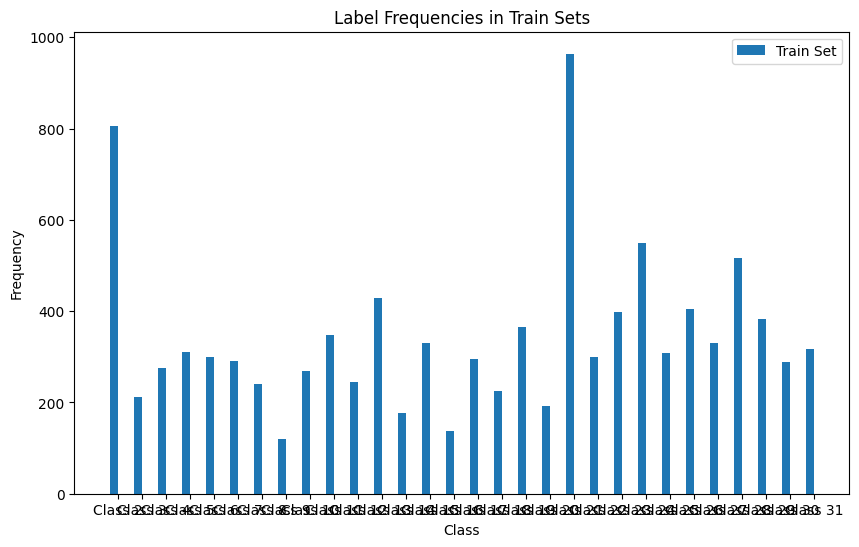

In [27]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_label_frequencies(train_labels, class_names):
#     # Count the occurrences of each label in the training set
#     train_label_counts = np.bincount(train_labels)

#     # Count the occurrences of each label in the test set

#     # Create a bar plot
#     fig, ax = plt.subplots(figsize=(10, 6))
#     bar_width = 0.35
#     index = np.arange(len(class_names))

#     # Plot training set frequencies
#     train_bars = ax.bar(index, train_label_counts, bar_width, label='Train Set')

#     # Plot test set frequencies

#     # Add labels, title, and legend
#     ax.set_xlabel('Class')
#     ax.set_ylabel('Frequency')
#     ax.set_title('Label Frequencies in Train Sets')
#     ax.set_xticks(index + bar_width / 2)
#     ax.set_xticklabels(class_names)
#     ax.legend()

#     # Show the plot
#     plt.show()

# # Extract labels from the data
# # train_labels = [train_dataset[i]['label'] for i in range(len(train_dataset))]
# # test_labels = [test_dataset[i]['label'] for i in range(len(test_dataset))]

# # List of class names
# class_names = [f'Class {i+1}' for i in range(1, len(set(all_train_labels)) + 1)]

# # Plot label frequencies
# plot_label_frequencies(all_train_labels, class_names)


# Start Training Process

In [20]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [55]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
# teacher_model.fc = nn.Linear(512,30)
# student_model = torchvision.models.resnet18(weights=None).to(device)
# student_model.fc = nn.Linear(512,30)


# # Load teacher
teacher_model = torch.load('teacher_model_ckd_prof.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_prof_checkpoint.pth'))
teacher_model = teacher_model.to(device)
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)




In [85]:
class Adversary(nn.Module):
    def __init__(self, identity_labels = 14):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(512,256)
        self.a2 = nn.Linear(256, identity_labels)

        nn.init.xavier_normal_(self.a1.weight)

    def forward(self, input_ids):


        #Adversary
        adversary = F.relu(self.a1(input_ids))
        adversary_output = self.a2(adversary)

        return adversary_output


adv = Adversary()
adv = adv.to(device)

In [86]:
feature_extractor = torch.nn.Sequential(*list(student_model.children())[:-1])



In [87]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)


# Instantiate the model and the loss function
criterion = nn.CrossEntropyLoss(weight=normalized_class_weights)



In [88]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

        return student

In [89]:
def pretrain_adversary(adv, student, optimizer, trainloader, criterion, epochs):
  
  pretrain_adversary_loss = 0
  steps = 0

  for epoch in range(epochs):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(trainloader): # starting from the 0th batch
        # get the inputs and labels
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)

        optimizer.zero_grad()

        classifier_prev_output = feature_extractor(inputs)
        adversary_output = adv(classifier_prev_output)
        adversary_loss = criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        optimizer_adv.step()
        pretrain_adversary_loss += adversary_loss.item()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1
        steps += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

  return adv

In [ ]:
pretrain_student(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=3, patience=5)
pretrain_adversary(adv, student_model, optimizer, trainloader, criterion, epochs=3)


  0%|                                                    | 0/28 [00:00<?, ?it/s]

In [23]:
def recall_disparity_loss(outputs, targets, attributes, class_labels_new):
    """
    Compute the recall disparity loss.

    :param outputs: Tensor of shape (batch_size, num_classes), model's class probabilities or logits.
    :param targets: Tensor of shape (batch_size,), true class indices.
    :param attributes: Tensor of shape (batch_size, num_attributes), binary attributes for each instance.
    :param num_classes: int, number of classes.
    """
    # Ensure we're working with probabilities
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

    # Initialize tensors to store recall for when attributes are present and absent
    recall_when_present = torch.zeros(num_classes, attributes.size(1))
    recall_when_absent = torch.zeros(num_classes, attributes.size(1))

    # Initialize the disparity matrix
    disparity = torch.zeros(num_classes, attributes.size(1))
    
    for class_idx in class_labels_new:
        for attr_idx in range(attributes.size(1)):
            # Indices of instances with the current class and attribute present/absent
            class_and_attr_present = (targets == class_idx) & (attributes[:, attr_idx] == 1)
            class_and_attr_absent = (targets == class_idx) & (attributes[:, attr_idx] == 0)
    
            # True positives for current class when attribute is present/absent
            true_positive_present = ((preds == class_idx) & class_and_attr_present).sum().float()
            true_positive_absent = ((preds == class_idx) & class_and_attr_absent).sum().float()
    
            # Condition positives for current class when attribute is present/absent
            condition_positive_present = class_and_attr_present.sum().float()
            condition_positive_absent = class_and_attr_absent.sum().float()
    
            # Check if both denominators are non-zero before calculating recall
            if condition_positive_present != 0 and condition_positive_absent != 0:
                recall_when_present[class_idx, attr_idx] = true_positive_present / condition_positive_present
                recall_when_absent[class_idx, attr_idx] = true_positive_absent / condition_positive_absent
    
                # Disparity is the absolute difference between recall when attribute is present and when it's absent
                disparity[class_idx, attr_idx] = (recall_when_present[class_idx, attr_idx] - recall_when_absent[class_idx, attr_idx]).abs()
    
    # Compute the average disparity
    average_disparity = disparity.mean().item()
    
    return average_disparity




In [24]:
# #### finding the optimal learning rate
# def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(num_epochs):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best learning rate: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
# print(best_lr)

In [25]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [26]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=1, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}| Validation Accuracy: {accuracy * 100:.2f}%')
            
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            # annot = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            previous_layer = get_features(inputs, "layer4")

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # disparity = recall_disparity_loss(student_outputs, labels, annot, class_labels_new)
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
            # if disparity.ndim != 0:
            #     disparity = disparity.sum()
            
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            # epoch_disparity += disparity

        
        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                # val_annot = val_data['target'].to(device)
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                with torch.no_grad():
                    val_teacher_outputs = teacher(val_inputs)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                # val_disparity = recall_disparity_loss(val_student_outputs, val_labels, class_labels_new)
                # If not scalar, sum up to make sure the loss is scalar
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                # if disparity.ndim != 0:
                #     disparity = disparity.sum()
                
                # Now combine the losses
                val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}| Validation Accuracy: {accuracy * 100:.2f}%')
            
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step()

    print("Finished Training Student")
    plot_loss_curve(val_losses)


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Epoch 1/15, Train Loss:  0.453982 Val Loss:  0.457637| Validation Accuracy: 8.86%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 2/15, Train Loss:  0.409949 Val Loss:  0.446523| Validation Accuracy: 9.15%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Epoch 3/15, Train Loss:  0.402812 Val Loss:  0.441848| Validation Accuracy: 9.53%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Epoch 4/15, Train Loss:  0.398947 Val Loss:  0.438994| Validation Accuracy: 9.82%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Epoch 5/15, Train Loss:  0.397602 Val Loss:  0.437494| Validation Accuracy: 10.14%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 6/15, Train Loss:  0.396211 Val Loss:  0.436198| Validation Accuracy: 10.14%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 7/15, Train Loss:  0.394802 Val Loss:  0.434447| Validation Accuracy: 10.19%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 8/15, Train Loss:  0.394357 Val Loss:  0.433353| Validation Accuracy: 10.40%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Epoch 9/15, Train Loss:  0.393850 Val Loss:  0.432118| Validation Accuracy: 10.80%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 10/15, Train Loss:  0.390975 Val Loss:  0.430961| Validation Accuracy: 11.18%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Epoch 11/15, Train Loss:  0.390955 Val Loss:  0.429382| Validation Accuracy: 11.76%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Epoch 12/15, Train Loss:  0.389033 Val Loss:  0.427864| Validation Accuracy: 12.16%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Epoch 13/15, Train Loss:  0.388135 Val Loss:  0.426635| Validation Accuracy: 12.77%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Epoch 14/15, Train Loss:  0.387997 Val Loss:  0.425321| Validation Accuracy: 12.97%


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


Epoch 15/15, Train Loss:  0.385873 Val Loss:  0.423834| Validation Accuracy: 13.18%
Finished Training Student


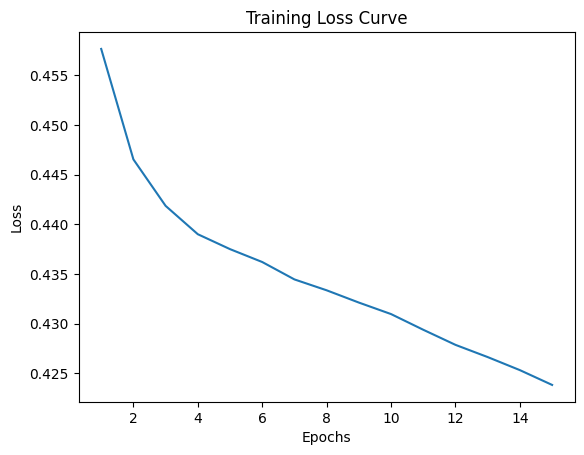

In [27]:
# Call the function to train the teacher model
# train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation_disparity(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


In [28]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_prof.pth')
torch.save(student_model, 'student_model_ckd_prof.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_prof.pth')
torch.save(teacher_model, 'teacher_model_ckd_prof.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


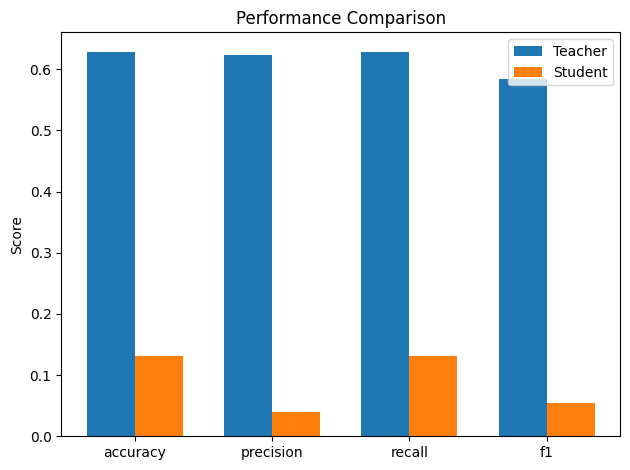

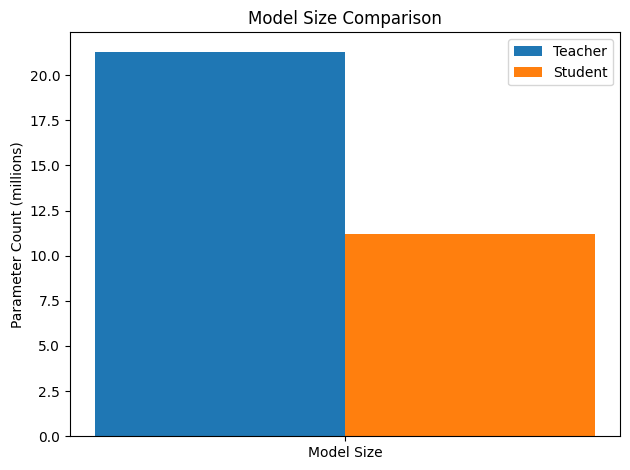

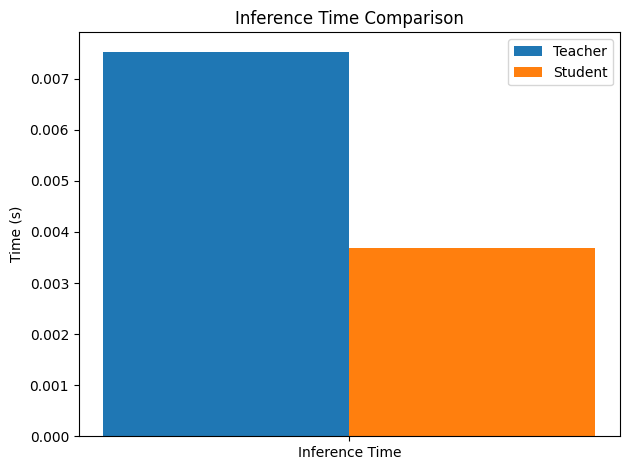

In [29]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics['metrics'][metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics['metrics'][metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [30]:
def calculate_recall(preds, targets, condition):
    """
    Calculate recall for a given condition in a multi-class setting.

    :param preds: Predicted classes.
    :param targets: True classes.
    :param condition: Boolean tensor indicating the condition (subset) for which to calculate recall.
    :return: Recall value.
    """
    if condition.sum() == 0:  # No samples meet the condition
        return 0.0

    filtered_preds = preds[condition]
    filtered_targets = targets[condition]

    true_positive = (filtered_preds == filtered_targets).sum().float()
    condition_positive = filtered_targets.size(0)

    recall = true_positive / condition_positive if condition_positive > 0 else 0.0
    return recall
    
def calculate_weighted_disparity(disparity_sums, counts):
    """
    Calculate weighted disparity for each class-attribute pair.
    """
    weighted_disparities = torch.zeros_like(disparity_sums)
    for class_idx in range(disparity_sums.size(0)):
        for attr_idx in range(disparity_sums.size(1)):
            if counts[class_idx][attr_idx] > 0:
                weighted_disparities[class_idx][attr_idx] = disparity_sums[class_idx][attr_idx] / counts[class_idx][attr_idx]
            else:
                weighted_disparities[class_idx][attr_idx] = 0.0
    return weighted_disparities

def evaluate_disparity(model, dataloader, num_classes, device):
    """
    Evaluate the disparity on the test data with weighted consideration.
    """
    model.eval()
    disparity_sums = None
    counts = None

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            targets = batch['label'].to(device)
            attributes = batch['target'].to(device)

            if disparity_sums is None:
                disparity_sums = torch.zeros(num_classes, attributes.size(1), device=device)
                counts = torch.zeros(num_classes, attributes.size(1), device=device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for class_idx in range(num_classes):
                for attr_idx in range(attributes.size(1)):
                    condition_present = (attributes[:, attr_idx] == 1) & (targets == class_idx)
                    condition_absent = (attributes[:, attr_idx] == 0) & (targets == class_idx)

                    if condition_present.sum() > 0 or condition_absent.sum() > 0:
                        recall_present = calculate_recall(preds, targets, condition_present)
                        recall_absent = calculate_recall(preds, targets, condition_absent)

                        disparity = abs(recall_present - recall_absent)
                        count = condition_present.sum() + condition_absent.sum()
                        disparity_sums[class_idx][attr_idx] += disparity * count
                        counts[class_idx][attr_idx] += count

    weighted_disparities = calculate_weighted_disparity(disparity_sums, counts)

    for class_idx in range(num_classes):
        for attr_idx in range(attributes.size(1)):
            print(f"Class: {class_idx}, Attr: {attr_idx}, Weighted Disparity: {weighted_disparities[class_idx][attr_idx]}")

    weighted_average = weighted_disparities.flatten()
    weighted_average = weighted_average.sum()/weighted_average.numel()
    return weighted_average

In [31]:
disparity = evaluate_disparity(student_model, testloader, num_classes=num_classes, device=device)
print(f'Average recall disparity across all attributes and classes: {disparity}')


KeyError: 'target'

In [ ]:
class_names_new = [f"Class {label}" for label in range(30)]
def plot_prediction_distribution_and_confusion_matrix(labels, preds, class_names):
    # Plotting the distribution of predictions
    sns.countplot(x=preds)
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.show()

    # Computing the confusion matrix
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names_new, columns=class_names_new)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report for detailed metrics
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))

performance_metrics_teacher = compare_performance_metrics(teacher_model, student_model, testloader)
all_labels = performance_metrics_teacher['all_labels']
all_teacher_preds = performance_metrics_teacher['all_teacher_preds']
all_student_preds = performance_metrics_teacher['all_student_preds']

# For the Teacher Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_teacher_preds, class_names_new)

# For the Student Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_student_preds, class_names_new)

In [47]:
student_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
feature_extractor = torch.nn.Sequential(*list(student_model.children())[:-1])


In [83]:
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con